In [2]:
import awkward as ak
import numpy as np
import os
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
plt.style.use("figures.mplstyle")

# Directory containing parquet files
base_dir = "Data/SIREN/Output/SINE_CMS_West/HNLs/"

# Regex to extract m4 and Um4 from filename
pattern = re.compile(r"m4_(\d+)_Um4_([0-9.]+)")

# Group files by (m4, Um4)
groups = defaultdict(list)
for fname in os.listdir(base_dir):
    if fname.endswith(".parquet"):
        match = pattern.search(fname)
        if match:
            m4 = match.group(1)
            Um4 = match.group(2).rstrip('.')
            groups[(m4, Um4)].append(os.path.join(base_dir, fname))




In [3]:
def compute_time_delay(siren_data,
                       hnl_mass, # GeV
                       c=2.998e-1):
    """Compute time delay for each event:
    1. Neutrino: primary_initial_position → first vertex
    2. HNL: first vertex → second vertex
    3. Muon: second vertex → panel intersection

    Args:
        siren_data: awkward array with event data
        c: speed of light in mm/ns
    """

    nu_dict = {"first_plane_x":[],
            "first_plane_y": [],
            "first_plane_z": [],
            "second_plane_x": [],
            "second_plane_y": [],
            "second_plane_z": [],
            "weights":[],
            "beam_timing":[],
            "timing_difference":[]
            }

    # 3x2 setup
    panel_width = 24.4
    panel_height = 7.77
    panel_bottom = 0
    # prototype setup
    # panel_width = 12.2
    # panel_height = 2.59
    # panel_bottom = (7.77-2.59)/2

    # compute HNL beta
    hnl_momentum = siren_data["primary_momentum"][:,1,:]
    hnl_gamma = hnl_momentum[:,0] / hnl_mass
    hnl_beta = np.sqrt(1 - 1/(hnl_gamma**2))


    for plane in [1,2,3]:
        mask = siren_data["panel%d_hit_mask_muon0_survival"%(plane)]==1
        int_locations = siren_data[f"muon0_panel{plane}_int_locations"][mask]
        int_distances = np.squeeze(siren_data[f"muon0_panel{plane}_int_distances"][mask])
        vertices = np.squeeze(siren_data["vertex"][mask])
        initial_pos = np.squeeze(siren_data["primary_initial_position"][mask])
        wgts = np.squeeze(siren_data["weights"][mask])
        betas = np.squeeze(hnl_beta[mask])
        for w, init_pos, vx, dist, loc, beta in zip(wgts, initial_pos, vertices, int_distances, int_locations, betas):

            # # distance checks
            first_plane_y = loc[0][1] - panel_bottom
            second_plane_y = loc[1][1] - panel_bottom
            if first_plane_y > panel_height or first_plane_y < 0 : continue
            if second_plane_y > panel_height or second_plane_y < 0: continue
            if abs(loc[0][0]) > panel_width/2: continue
            if abs(loc[1][0]) > panel_width/2: continue
            if (loc[1][2] - loc[0][2]) <= 2.44 - 1e-6: continue # make sure we enter in front, exit in back

            # Time components:
            # print(vx[0])
            # print(vx[1])
            # print(dist[0])
            # print(loc[0])
            t_nu = np.linalg.norm(vx[0] - init_pos[0]) / c  # neutrino time
            t_hnl = np.linalg.norm(vx[1] - vx[0]) / (beta*c)    # HNL time
            t_muon = dist[0] / c                         # muon time in panel
            total_time = t_nu + t_hnl + t_muon
            # Light travel time from origin to intersection point
            light_time = np.linalg.norm(loc[0] - init_pos[0]) / c  # Time for light from initial neutrino position to hit point)

            nu_dict["beam_timing"].append(total_time)
            nu_dict["timing_difference"].append(total_time - light_time)
            nu_dict["first_plane_x"].append(loc[0][0])
            nu_dict["first_plane_y"].append(first_plane_y)
            nu_dict["first_plane_z"].append(loc[0][2])
            nu_dict["second_plane_x"].append(loc[1][0])
            nu_dict["second_plane_y"].append(second_plane_y)
            nu_dict["second_plane_z"].append(loc[1][2])
            nu_dict["weights"].append(w)
    return nu_dict



In [4]:
# Compute sum for each group

dimuon_rate = {}
timing_dict = {}
for (m4, Um4), files in groups.items():
    if m4!="1000" and m4!="10000": continue
    #if float(Um4)<0.01: continue
    print(f"Processing m4: {m4}, Um4: {Um4} with {len(files)} files")
    dimuon_total = 0.0
    nu_dict = {}
    for f in files:
        data = ak.from_parquet(f)
        # Make sure arrays are numpy for multiplication
        weights = np.array(data["weights"])
        dimuon_mask = np.array(data["hit_mask_dimuon_survival"])
        dimuon_total += np.sum(weights * dimuon_mask)
        _data = compute_time_delay(data,float(m4)/1000.0)  # Convert m4 from MeV to GeV
        for key in _data:
            if key not in nu_dict:
                nu_dict[key] = []
            nu_dict[key].extend(_data[key])
    dimuon_rate[(m4, Um4)] = dimuon_total
    timing_dict[(m4, Um4)] = nu_dict

Processing m4: 10000, Um4: 0.02154 with 4 files


/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:290: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


Processing m4: 1000, Um4: 0.00278 with 4 files
Processing m4: 10000, Um4: 0.03594 with 4 files
Processing m4: 10000, Um4: 0.00167 with 4 files
Processing m4: 1000, Um4: 0.00100 with 4 files
Processing m4: 1000, Um4: 0.05995 with 4 files
Processing m4: 1000, Um4: 0.00774 with 4 files
Processing m4: 10000, Um4: 0.10000 with 4 files
Processing m4: 1000, Um4: 0.03594 with 4 files
Processing m4: 1000, Um4: 0.10000 with 4 files
Processing m4: 10000, Um4: 0.01292 with 4 files
Processing m4: 1000, Um4: 0.00167 with 4 files
Processing m4: 1000, Um4: 0.02154 with 4 files
Processing m4: 10000, Um4: 0.00100 with 4 files
Processing m4: 1000, Um4: 0.00464 with 4 files
Processing m4: 10000, Um4: 0.05995 with 4 files
Processing m4: 10000, Um4: 0.00464 with 4 files
Processing m4: 10000, Um4: 0.00278 with 4 files
Processing m4: 1000, Um4: 0.01292 with 4 files
Processing m4: 10000, Um4: 0.00774 with 4 files


In [5]:
timing_cut = 1 # ns
delayed_muon_rate = {}
for k,nu_dict in timing_dict.items():
    delayed_muon_rate[k] = np.sum(np.array(nu_dict["weights"])[np.array(nu_dict["timing_difference"])>timing_cut])


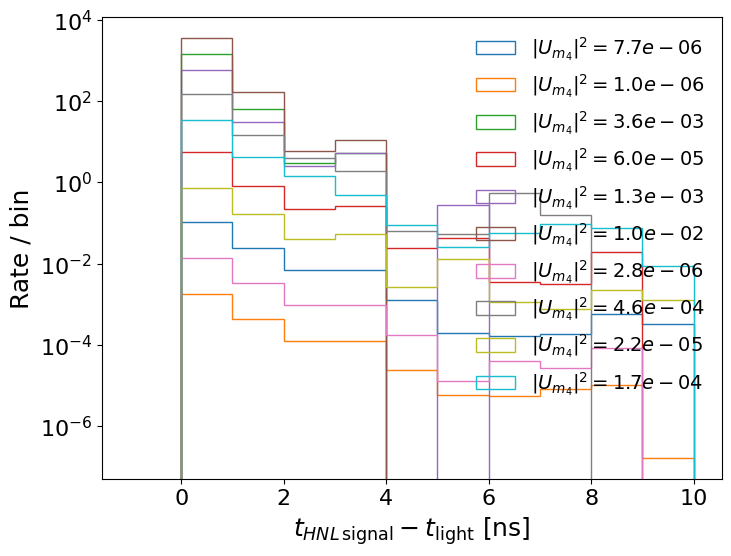

In [6]:
for k,nu_dict in timing_dict.items():
    if k[0]!="1000": continue
    plt.hist(np.array(nu_dict["timing_difference"]),
            weights=nu_dict["weights"],
            bins=np.linspace(-1,10,12),
            histtype="step",
            label=r"$|U_{m_4}|^2=%1.1e$"%(float(k[1])**2))
plt.xlabel(r"$t_{HNL \,{\rm signal}} - t_{\rm light}$ [ns]")
plt.ylabel("Rate / bin")
plt.legend(loc="upper right",fontsize=14)
plt.semilogy()
plt.show()

/tmp/ipykernel_3090808/2296243275.py:26: UserWarning: The following kwargs were not used by contour: 'labels'
  contours = plt.contour(X, Y, Z, levels=[1,3],colors=[color],linestyles=["-","--"],labels=["1 event","10 events"])


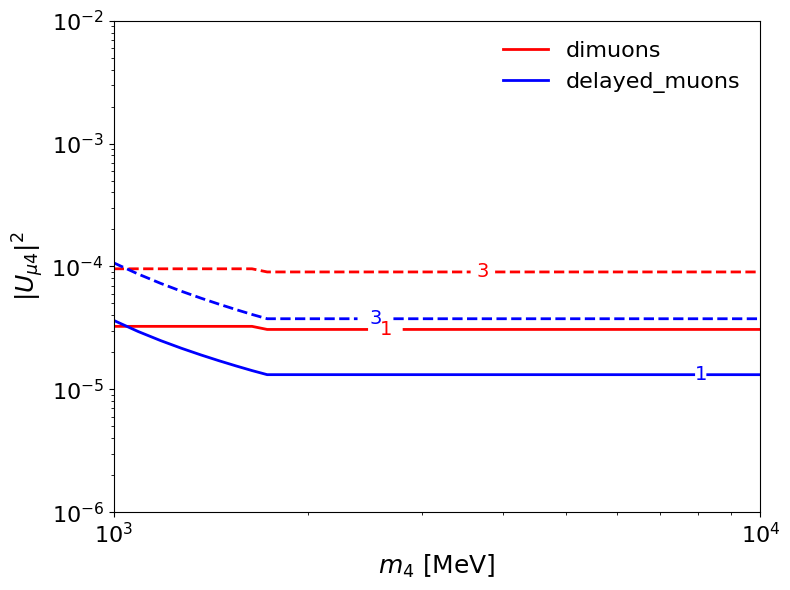

In [7]:
plt.figure(figsize=(8,6))
for k,results in zip(["dimuons","delayed_muons"],
                     [dimuon_rate, delayed_muon_rate]):

    color = "red" if k=="dimuons" else "blue"



    # Prepare data
    m4_vals = np.array([int(k[0]) for k in results.keys()])
    Um4_sq_vals = np.array([float(k[1])**2 for k in results.keys()])
    event_sums = np.array(list(results.values()))

    # Define grid for interpolation
    m4_grid = np.linspace(m4_vals.min(), m4_vals.max(), 100)
    Um4_sq_grid = np.linspace(Um4_sq_vals.min(), Um4_sq_vals.max(), 100)
    X, Y = np.meshgrid(m4_grid, Um4_sq_grid)

    # Interpolate event_sums onto grid
    Z = griddata((m4_vals, Um4_sq_vals), event_sums, (X, Y), method='linear', fill_value=0)


    #pcm = plt.pcolormesh(X, Y, Z, cmap='viridis',norm=LogNorm())
    #sc = plt.scatter(m4_vals, Um4_sq_vals, c=event_sums, cmap='viridis', s=80,norm=LogNorm(vmin=1e-1))
    #plt.colorbar(sc, label='Number of HNL dimuons in SINE')
    contours = plt.contour(X, Y, Z, levels=[1,3],colors=[color],linestyles=["-","--"],labels=["1 event","10 events"])
    plt.clabel(contours,fontsize=14)
    plt.plot([],[], color=color, label=k)
plt.xlabel(r'$m_4$ [MeV]')
plt.ylabel(r'$|U_{\mu 4}|^2$')
plt.loglog()
plt.ylim(1e-6,1e-2)
plt.tight_layout()
plt.legend()
plt.show()

# Cross section comparison

In [ ]:
import siren
import os
# Now include DIS interaction
cross_section_model = "HNLDISSplines"

xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

nutype = "nu"
primary = 14
primary_type = (siren.dataclasses.Particle.ParticleType)(primary)

m4 = "0002000"
Ue4 = 0
Umu4 = 0.01
Utau4 = 0

HNL_DIS_xs = siren.interactions.HNLDISFromSpline(
    os.path.join(xsfiledir, "M_0000000MeV/dsdxdy-%s-N-nc-GRV98lo_patched_central.fits"%nutype),
    os.path.join(xsfiledir, "M_%sMeV/sigma-%s-N-nc-GRV98lo_patched_central.fits"%(m4,nutype)),
    float(m4)*1e-3,
    [Ue4,Umu4,Utau4],
    siren.utilities.Constants.isoscalarMass,
    1,
    [primary_type],
    [target_type],
)
xsfiledir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/pweigel/cross_sections/20241017"

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon
nutype = "neutrino"
nuflavor = "muon"
xs_mode = "NC"
minQ2 = 1

DIS_xs = siren.interactions.DISFromSpline(
        os.path.join(xsfiledir, "wcg24b_dsdxdy_%s_%s_%s_isoscalar.fits"%(xs_mode,nuflavor,nutype)),
        os.path.join(xsfiledir, "wcg24b_sigma_%s_%s_%s_isoscalar.fits"%(xs_mode,nuflavor,nutype)),
        1,siren.utilities.Constants.isoscalarMass,minQ2,
        [primary_type],
        [target_type], "cm"
    )

In [ ]:

DIS_xs.TotalCrossSection(primary_type,100) # cm^2

1.9537232154384104e-37

In [ ]:
HNL_DIS_xs.TotalCrossSection(primary_type,100)# * 1e18 * siren.utilities.Constants.hbarc**2 * 1e4 # cm^2

1.8053350135272425e-41